In [ ]:
## This is the data preprocessing step -- this is where the
import wandb
import boto3
import json
import sys

In [ ]:
entity='ruban-kumar-ascentt'
project='cvo'

def preprocessing():

  ### some preprocessing steps as normal
  ### NOTHING changes in the way you store data
  dataset = {"some": "data", 'mm' : 'mm'}

  ### At the end, store data in s3

  s3 = boto3.resource('s3')

  # save data pipe
  response = s3.Bucket('cvo-dev-filestorage').put_object(Key='somedata.json', Body=json.dumps(dataset))

  #hash params
  art_metadata = {
      "vehcile": "rav4",
      "business_month": "bus",
      "de_user": "de",
      "ds_month": "thisistheone",
      "version": "v"
  }

  ### Log the data in wandb
  run = wandb.init(entity=entity, job_type="preprocessing",project=project, save_code=True, force=True)
  ## Create an artifact w/ the desired metadata
  data_art = wandb.Artifact('raw2', type='metadata', metadata=art_metadata)
  ## add the reference to s3  
  data_art.add_reference('s3://cvo-dev-filestorage/somedata.json')
  ## log it to wandb
  run.log_artifact(data_art)

preprocessing()

In [ ]:
artifact = wandb.Artifact(
      name='my-data-obj',
      type='dataset',
      metadata= {
        "environment": "env",
        "business_month": "bus",
        "de_user": "de",
        "ds_month": "thisistheone",
        "version": "v"
      }
)

In [ ]:
## This function returns a W&B artifact ref name from the given project and type
## by looking for a key/value pair and returns it as string reference
def find_artifact_by_metadata_search(key: str, value: str, p_name: str, art_type: str) -> str:
        # Get an API interaction object
        wandbapi = wandb.Api()
        # Get all artifacts under a project that are datasets
        arts = wandbapi.artifact_collections(type_name=art_type, project_name=p_name)

        art_to_use = "notfound"
        # print([i.artifacts() for i in arts])
        # Find art with the right value in the metadata
        result = []
        for art_col in arts:
          print(art_col)
          for art_single_version in art_col.artifacts():
            print(art_single_version)
            for art_key, art_value in art_single_version.metadata.items():
              if (art_key == key and art_value == value):
                result.append(
                   {
                      'name' : art_single_version.name, 
                      'id' : art_single_version.id, 
                      'file_count' :art_single_version.file_count, 
                      # 'version' :art_single_version.verison,
                      'created_at' : art_single_version.created_at
                      # 'aliases' : art_single_version.aliases
                   }
                )
                #art_to_use = art_single_version.name
                # for file in art_single_version.files:
                #    print(file)
                #    art_url = file
                #art_url = art_single_version.files
                   
            
        return result


print(find_artifact_by_metadata_search(key="ds_month", value="thisistheone", p_name=project, art_type="dataset"))

In [ ]:
### This is the model training step
## You may want to look for artifact metadata in order to pick the right one under a project
## This code shows how to do that
import wandb

entity='wandb-smle'
project='abe-ref-artifacts'


def model_training():
  with wandb.init(entity=entity, job_type="training",
        project=project, save_code=True, force=True) as run:

        art_ref_name = find_artifact_by_metadata_search("ds_month", "thisistheone", project, "dataset")

        # Finally you fetch the artifact and download the data
        artifact = wandb.use_artifact(f'{project}/{art_ref_name}', type='dataset')
        artifact_dir = artifact.download()

        # Then you go on happily ever after to train your model
        # Note you never sent the data to wandb, just the reference
        # When you tell wandb to download the artifact, it is actually downloading it straight from s3

model_training()

Your lineage in wandb then looks like:
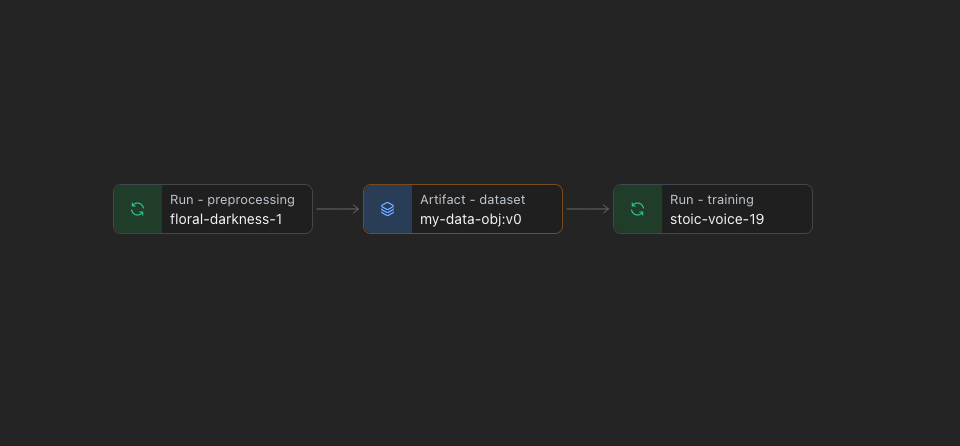